In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128_exp", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.relu(out, inplace=False)  # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x, inplace=False)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_CIFAR10-DVS_ReLU_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_exp.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, mom

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): Batch

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=300,save_best=True, save_thr=48)

100%|██████████| 219/219 [00:52<00:00,  4.13it/s]


Epoch [1/300], Step [219/219], Loss: 12.9212, Accuracy: 0.1134
Accuracy of the network: 0.13666666666666666 Loss: 2.4421238011502204


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [2/300], Step [219/219], Loss: 2.3129, Accuracy: 0.1236
Accuracy of the network: 0.143 Loss: 2.2620539360858025


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [3/300], Step [219/219], Loss: 2.2169, Accuracy: 0.1560
Accuracy of the network: 0.164 Loss: 2.181614032451143


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [4/300], Step [219/219], Loss: 2.1856, Accuracy: 0.1664
Accuracy of the network: 0.189 Loss: 2.140444796136085


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [5/300], Step [219/219], Loss: 2.1921, Accuracy: 0.1619
Accuracy of the network: 0.17633333333333334 Loss: 2.1408586628893587


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [6/300], Step [219/219], Loss: 2.1694, Accuracy: 0.1710
Accuracy of the network: 0.13966666666666666 Loss: 2.189858460679967


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [7/300], Step [219/219], Loss: 2.1652, Accuracy: 0.1671
Accuracy of the network: 0.17933333333333334 Loss: 2.12633542177525


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [8/300], Step [219/219], Loss: 2.1503, Accuracy: 0.1731
Accuracy of the network: 0.16966666666666666 Loss: 2.135830785365815


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [9/300], Step [219/219], Loss: 2.1447, Accuracy: 0.1744
Accuracy of the network: 0.176 Loss: 2.152939777424995


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [10/300], Step [219/219], Loss: 2.1369, Accuracy: 0.1756
Accuracy of the network: 0.19733333333333333 Loss: 2.1085695205850805


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [11/300], Step [219/219], Loss: 2.1252, Accuracy: 0.1726
Accuracy of the network: 0.182 Loss: 2.1700137105393917


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [12/300], Step [219/219], Loss: 2.1311, Accuracy: 0.1789
Accuracy of the network: 0.19 Loss: 2.1018686281873826


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [13/300], Step [219/219], Loss: 2.1251, Accuracy: 0.1817
Accuracy of the network: 0.17766666666666667 Loss: 2.1158383729610035


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [14/300], Step [219/219], Loss: 2.1184, Accuracy: 0.1886
Accuracy of the network: 0.195 Loss: 2.083693799820352


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [15/300], Step [219/219], Loss: 2.1093, Accuracy: 0.1836
Accuracy of the network: 0.188 Loss: 2.111900933245395


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [16/300], Step [219/219], Loss: 2.1128, Accuracy: 0.1770
Accuracy of the network: 0.19633333333333333 Loss: 2.1061774111808615


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [17/300], Step [219/219], Loss: 2.0988, Accuracy: 0.1803
Accuracy of the network: 0.18666666666666668 Loss: 2.0797861180406936


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [18/300], Step [219/219], Loss: 2.0964, Accuracy: 0.1823
Accuracy of the network: 0.17566666666666667 Loss: 2.1107280406546085


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [19/300], Step [219/219], Loss: 2.0991, Accuracy: 0.1954
Accuracy of the network: 0.191 Loss: 2.0850870799511037


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [20/300], Step [219/219], Loss: 2.0923, Accuracy: 0.1899
Accuracy of the network: 0.17833333333333334 Loss: 2.1414722927073213


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [21/300], Step [219/219], Loss: 2.0853, Accuracy: 0.1923
Accuracy of the network: 0.21766666666666667 Loss: 2.065388860854697


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [22/300], Step [219/219], Loss: 2.0865, Accuracy: 0.1899
Accuracy of the network: 0.199 Loss: 2.1168533741159643


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [23/300], Step [219/219], Loss: 2.0755, Accuracy: 0.1963
Accuracy of the network: 0.205 Loss: 2.0527867687509413


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [24/300], Step [219/219], Loss: 2.0735, Accuracy: 0.1934
Accuracy of the network: 0.18 Loss: 2.0947637050709824


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [25/300], Step [219/219], Loss: 2.0786, Accuracy: 0.1944
Accuracy of the network: 0.20533333333333334 Loss: 2.0660744486971105


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [26/300], Step [219/219], Loss: 2.0798, Accuracy: 0.1994
Accuracy of the network: 0.19733333333333333 Loss: 2.0638211394878145


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [27/300], Step [219/219], Loss: 2.0750, Accuracy: 0.1964
Accuracy of the network: 0.195 Loss: 2.126503423173377


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [28/300], Step [219/219], Loss: 2.0676, Accuracy: 0.2057
Accuracy of the network: 0.201 Loss: 2.0561064532462585


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [29/300], Step [219/219], Loss: 2.0547, Accuracy: 0.2097
Accuracy of the network: 0.21366666666666667 Loss: 2.0651134468139487


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [30/300], Step [219/219], Loss: 2.0258, Accuracy: 0.2211
Accuracy of the network: 0.24066666666666667 Loss: 1.9933226476324366


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [31/300], Step [219/219], Loss: 1.9800, Accuracy: 0.2481
Accuracy of the network: 0.256 Loss: 1.9605137046347274


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [32/300], Step [219/219], Loss: 1.9484, Accuracy: 0.2546
Accuracy of the network: 0.25966666666666666 Loss: 1.9717032795256757


100%|██████████| 219/219 [00:53<00:00,  4.13it/s]


Epoch [33/300], Step [219/219], Loss: 1.9450, Accuracy: 0.2554
Accuracy of the network: 0.247 Loss: 1.9731482495652868


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [34/300], Step [219/219], Loss: 1.9248, Accuracy: 0.2676
Accuracy of the network: 0.28 Loss: 1.9131706052638116


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [35/300], Step [219/219], Loss: 1.9122, Accuracy: 0.2704
Accuracy of the network: 0.273 Loss: 1.9070046252392707


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [36/300], Step [219/219], Loss: 1.9010, Accuracy: 0.2897
Accuracy of the network: 0.29333333333333333 Loss: 1.8853396354837622


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [37/300], Step [219/219], Loss: 1.8614, Accuracy: 0.2946
Accuracy of the network: 0.306 Loss: 1.8778622315285054


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [38/300], Step [219/219], Loss: 1.8618, Accuracy: 0.2989
Accuracy of the network: 0.306 Loss: 1.836759384642256


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [39/300], Step [219/219], Loss: 1.8384, Accuracy: 0.3093
Accuracy of the network: 0.33066666666666666 Loss: 1.833534006108629


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [40/300], Step [219/219], Loss: 1.8068, Accuracy: 0.3217
Accuracy of the network: 0.344 Loss: 1.8110639757298408


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [41/300], Step [219/219], Loss: 1.7982, Accuracy: 0.3206
Accuracy of the network: 0.3526666666666667 Loss: 1.760678380093676


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [42/300], Step [219/219], Loss: 1.7757, Accuracy: 0.3336
Accuracy of the network: 0.3446666666666667 Loss: 1.7828751092261457


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [43/300], Step [219/219], Loss: 1.7715, Accuracy: 0.3479
Accuracy of the network: 0.3363333333333333 Loss: 1.7813001363835437


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [44/300], Step [219/219], Loss: 1.7668, Accuracy: 0.3469
Accuracy of the network: 0.3473333333333333 Loss: 1.7598206806690135


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [45/300], Step [219/219], Loss: 1.7317, Accuracy: 0.3601
Accuracy of the network: 0.33866666666666667 Loss: 1.779164934411962


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [46/300], Step [219/219], Loss: 1.7324, Accuracy: 0.3600
Accuracy of the network: 0.3436666666666667 Loss: 1.7949730348079762


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [47/300], Step [219/219], Loss: 1.7192, Accuracy: 0.3640
Accuracy of the network: 0.36433333333333334 Loss: 1.730698529710161


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [48/300], Step [219/219], Loss: 1.7003, Accuracy: 0.3684
Accuracy of the network: 0.356 Loss: 1.7347005542288436


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [49/300], Step [219/219], Loss: 1.6757, Accuracy: 0.3787
Accuracy of the network: 0.37933333333333336 Loss: 1.6860231287935947


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [50/300], Step [219/219], Loss: 1.6622, Accuracy: 0.3869
Accuracy of the network: 0.37933333333333336 Loss: 1.6929993604091889


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [51/300], Step [219/219], Loss: 1.6608, Accuracy: 0.3894
Accuracy of the network: 0.39666666666666667 Loss: 1.6743039006882525


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [52/300], Step [219/219], Loss: 1.6439, Accuracy: 0.3924
Accuracy of the network: 0.384 Loss: 1.6874303614839594


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [53/300], Step [219/219], Loss: 1.6358, Accuracy: 0.3976
Accuracy of the network: 0.3963333333333333 Loss: 1.662398506986334


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [54/300], Step [219/219], Loss: 1.6329, Accuracy: 0.4023
Accuracy of the network: 0.4013333333333333 Loss: 1.6359520123360005


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [55/300], Step [219/219], Loss: 1.6059, Accuracy: 0.4097
Accuracy of the network: 0.413 Loss: 1.6277350783348083


100%|██████████| 219/219 [00:53<00:00,  4.13it/s]


Epoch [56/300], Step [219/219], Loss: 1.5902, Accuracy: 0.4191
Accuracy of the network: 0.39966666666666667 Loss: 1.646961066317051


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [57/300], Step [219/219], Loss: 1.5722, Accuracy: 0.4211
Accuracy of the network: 0.4176666666666667 Loss: 1.612145704157809


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [58/300], Step [219/219], Loss: 1.5579, Accuracy: 0.4259
Accuracy of the network: 0.42033333333333334 Loss: 1.6110159272843219


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [59/300], Step [219/219], Loss: 1.5548, Accuracy: 0.4357
Accuracy of the network: 0.41833333333333333 Loss: 1.6027555554471118


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [60/300], Step [219/219], Loss: 1.5270, Accuracy: 0.4431
Accuracy of the network: 0.42 Loss: 1.6125444630359083


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [61/300], Step [219/219], Loss: 1.5179, Accuracy: 0.4551
Accuracy of the network: 0.44 Loss: 1.5711477715918358


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [62/300], Step [219/219], Loss: 1.5002, Accuracy: 0.4589
Accuracy of the network: 0.436 Loss: 1.567513512804153


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [63/300], Step [219/219], Loss: 1.5008, Accuracy: 0.4579
Accuracy of the network: 0.44233333333333336 Loss: 1.5827727330491899


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [64/300], Step [219/219], Loss: 1.4919, Accuracy: 0.4663
Accuracy of the network: 0.44566666666666666 Loss: 1.5703272464427542


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [65/300], Step [219/219], Loss: 1.4829, Accuracy: 0.4671
Accuracy of the network: 0.43866666666666665 Loss: 1.570340779233486


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [66/300], Step [219/219], Loss: 1.4703, Accuracy: 0.4769
Accuracy of the network: 0.45 Loss: 1.565423844976628


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [67/300], Step [219/219], Loss: 1.4661, Accuracy: 0.4767
Accuracy of the network: 0.445 Loss: 1.5610031269966287


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [68/300], Step [219/219], Loss: 1.4514, Accuracy: 0.4779
Accuracy of the network: 0.45366666666666666 Loss: 1.5467408451628177


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [69/300], Step [219/219], Loss: 1.4403, Accuracy: 0.4819
Accuracy of the network: 0.4623333333333333 Loss: 1.5188584321356835


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [70/300], Step [219/219], Loss: 1.4209, Accuracy: 0.4943
Accuracy of the network: 0.461 Loss: 1.5243024711913251


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [71/300], Step [219/219], Loss: 1.4122, Accuracy: 0.4987
Accuracy of the network: 0.45466666666666666 Loss: 1.5400514387069864


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [72/300], Step [219/219], Loss: 1.3958, Accuracy: 0.5020
Accuracy of the network: 0.45966666666666667 Loss: 1.5082538546399866


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [73/300], Step [219/219], Loss: 1.3967, Accuracy: 0.5041
Accuracy of the network: 0.4503333333333333 Loss: 1.5279035454100751


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [74/300], Step [219/219], Loss: 1.3932, Accuracy: 0.5061
Accuracy of the network: 0.456 Loss: 1.499556136892197


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [75/300], Step [219/219], Loss: 1.3940, Accuracy: 0.5011
Accuracy of the network: 0.4746666666666667 Loss: 1.5009470594690202


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [76/300], Step [219/219], Loss: 1.3777, Accuracy: 0.5070
Accuracy of the network: 0.4656666666666667 Loss: 1.5008350915097175


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [77/300], Step [219/219], Loss: 1.3654, Accuracy: 0.5147
Accuracy of the network: 0.4686666666666667 Loss: 1.4832984779743439


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [78/300], Step [219/219], Loss: 1.3598, Accuracy: 0.5131
Accuracy of the network: 0.475 Loss: 1.4837063081721042


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [79/300], Step [219/219], Loss: 1.3600, Accuracy: 0.5206
Accuracy of the network: 0.4696666666666667 Loss: 1.4975651952814548


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [80/300], Step [219/219], Loss: 1.3607, Accuracy: 0.5150
Accuracy of the network: 0.48 Loss: 1.468955008273429


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [81/300], Step [219/219], Loss: 1.3510, Accuracy: 0.5189
Accuracy of the network: 0.4656666666666667 Loss: 1.494974415353004


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [82/300], Step [219/219], Loss: 1.3303, Accuracy: 0.5300
Accuracy of the network: 0.48133333333333334 Loss: 1.458817239771498


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [83/300], Step [219/219], Loss: 1.3271, Accuracy: 0.5280
Accuracy of the network: 0.473 Loss: 1.4753276477468775


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [84/300], Step [219/219], Loss: 1.3175, Accuracy: 0.5263
Accuracy of the network: 0.468 Loss: 1.4728151908580294


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [85/300], Step [219/219], Loss: 1.3167, Accuracy: 0.5331
Accuracy of the network: 0.485 Loss: 1.4629817097745044


100%|██████████| 219/219 [00:49<00:00,  4.40it/s]


Epoch [86/300], Step [219/219], Loss: 1.3125, Accuracy: 0.5391
Accuracy of the network: 0.472 Loss: 1.46760948034043


100%|██████████| 219/219 [00:49<00:00,  4.41it/s]


Epoch [87/300], Step [219/219], Loss: 1.3136, Accuracy: 0.5347
Accuracy of the network: 0.477 Loss: 1.4745585664789727


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [88/300], Step [219/219], Loss: 1.3059, Accuracy: 0.5426
Accuracy of the network: 0.482 Loss: 1.4594552656437487


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [89/300], Step [219/219], Loss: 1.2953, Accuracy: 0.5390
Accuracy of the network: 0.49433333333333335 Loss: 1.4416922692288743


100%|██████████| 219/219 [00:50<00:00,  4.37it/s]


Epoch [90/300], Step [219/219], Loss: 1.2924, Accuracy: 0.5429
Accuracy of the network: 0.48733333333333334 Loss: 1.4276696468921417


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [91/300], Step [219/219], Loss: 1.2860, Accuracy: 0.5493
Accuracy of the network: 0.49533333333333335 Loss: 1.4326530542779476


100%|██████████| 219/219 [00:56<00:00,  3.90it/s]


Epoch [92/300], Step [219/219], Loss: 1.2943, Accuracy: 0.5441
Accuracy of the network: 0.49566666666666664 Loss: 1.4411765191149204


100%|██████████| 219/219 [00:54<00:00,  4.00it/s]


Epoch [93/300], Step [219/219], Loss: 1.2816, Accuracy: 0.5456
Accuracy of the network: 0.49733333333333335 Loss: 1.4271472109125016


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]


Epoch [94/300], Step [219/219], Loss: 1.2614, Accuracy: 0.5581
Accuracy of the network: 0.49 Loss: 1.4490528309598882


100%|██████████| 219/219 [00:49<00:00,  4.39it/s]


Epoch [95/300], Step [219/219], Loss: 1.2788, Accuracy: 0.5521
Accuracy of the network: 0.49766666666666665 Loss: 1.4331369349297056


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [96/300], Step [219/219], Loss: 1.2598, Accuracy: 0.5574
Accuracy of the network: 0.49366666666666664 Loss: 1.4414362488908972


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [97/300], Step [219/219], Loss: 1.2447, Accuracy: 0.5576
Accuracy of the network: 0.48933333333333334 Loss: 1.439702053019341


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [98/300], Step [219/219], Loss: 1.2587, Accuracy: 0.5574
Accuracy of the network: 0.48933333333333334 Loss: 1.4352880830460406


100%|██████████| 219/219 [00:54<00:00,  4.04it/s]


Epoch [99/300], Step [219/219], Loss: 1.2449, Accuracy: 0.5640
Accuracy of the network: 0.5 Loss: 1.429468221486883


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [100/300], Step [219/219], Loss: 1.2496, Accuracy: 0.5597
Accuracy of the network: 0.492 Loss: 1.4525180763386665


100%|██████████| 219/219 [00:52<00:00,  4.14it/s]


Epoch [101/300], Step [219/219], Loss: 1.2509, Accuracy: 0.5553
Accuracy of the network: 0.487 Loss: 1.4363599229366222


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [102/300], Step [219/219], Loss: 1.2300, Accuracy: 0.5659
Accuracy of the network: 0.489 Loss: 1.4533291281537806


100%|██████████| 219/219 [00:52<00:00,  4.15it/s]


Epoch [103/300], Step [219/219], Loss: 1.2447, Accuracy: 0.5637
Accuracy of the network: 0.503 Loss: 1.4161328242180196


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [104/300], Step [219/219], Loss: 1.2362, Accuracy: 0.5660
Accuracy of the network: 0.5103333333333333 Loss: 1.4095839889759714


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [105/300], Step [219/219], Loss: 1.2313, Accuracy: 0.5663
Accuracy of the network: 0.5056666666666667 Loss: 1.4195603690248855


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [106/300], Step [219/219], Loss: 1.2339, Accuracy: 0.5590
Accuracy of the network: 0.509 Loss: 1.4154189977240055


100%|██████████| 219/219 [00:54<00:00,  4.03it/s]


Epoch [107/300], Step [219/219], Loss: 1.2247, Accuracy: 0.5680
Accuracy of the network: 0.49766666666666665 Loss: 1.4159692246863183


100%|██████████| 219/219 [00:53<00:00,  4.12it/s]


Epoch [108/300], Step [219/219], Loss: 1.2197, Accuracy: 0.5706
Accuracy of the network: 0.5056666666666667 Loss: 1.4133278917759022


100%|██████████| 219/219 [00:53<00:00,  4.08it/s]


Epoch [109/300], Step [219/219], Loss: 1.2121, Accuracy: 0.5737
Accuracy of the network: 0.49966666666666665 Loss: 1.423821156329297


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [110/300], Step [219/219], Loss: 1.2185, Accuracy: 0.5683
Accuracy of the network: 0.506 Loss: 1.422244834773084


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [111/300], Step [219/219], Loss: 1.2115, Accuracy: 0.5750
Accuracy of the network: 0.503 Loss: 1.4073330392228796


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [112/300], Step [219/219], Loss: 1.2150, Accuracy: 0.5696
Accuracy of the network: 0.512 Loss: 1.4192633742981768


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [113/300], Step [219/219], Loss: 1.2074, Accuracy: 0.5743
Accuracy of the network: 0.512 Loss: 1.4043834786465828


100%|██████████| 219/219 [00:51<00:00,  4.23it/s]


Epoch [114/300], Step [219/219], Loss: 1.1974, Accuracy: 0.5800
Accuracy of the network: 0.5053333333333333 Loss: 1.4210228102004274


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [115/300], Step [219/219], Loss: 1.2099, Accuracy: 0.5749
Accuracy of the network: 0.5066666666666667 Loss: 1.4076731236691171


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [116/300], Step [219/219], Loss: 1.2037, Accuracy: 0.5779
Accuracy of the network: 0.5036666666666667 Loss: 1.4118574458233855


100%|██████████| 219/219 [00:54<00:00,  4.03it/s]


Epoch [117/300], Step [219/219], Loss: 1.2051, Accuracy: 0.5749
Accuracy of the network: 0.504 Loss: 1.4104297757148743


100%|██████████| 219/219 [00:53<00:00,  4.09it/s]


Epoch [118/300], Step [219/219], Loss: 1.1968, Accuracy: 0.5734
Accuracy of the network: 0.512 Loss: 1.3996101237357932


100%|██████████| 219/219 [00:53<00:00,  4.06it/s]


Epoch [119/300], Step [219/219], Loss: 1.2134, Accuracy: 0.5761
Accuracy of the network: 0.5076666666666667 Loss: 1.4015746300524854


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [120/300], Step [219/219], Loss: 1.1990, Accuracy: 0.5800
Accuracy of the network: 0.5156666666666667 Loss: 1.4066342064674864


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [121/300], Step [219/219], Loss: 1.1983, Accuracy: 0.5779
Accuracy of the network: 0.504 Loss: 1.3922570639468255


100%|██████████| 219/219 [00:53<00:00,  4.07it/s]


Epoch [122/300], Step [219/219], Loss: 1.1951, Accuracy: 0.5771
Accuracy of the network: 0.5073333333333333 Loss: 1.4047454582883956


100%|██████████| 219/219 [00:53<00:00,  4.11it/s]


Epoch [123/300], Step [219/219], Loss: 1.1788, Accuracy: 0.5860
Accuracy of the network: 0.5093333333333333 Loss: 1.4096721956070433


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [124/300], Step [219/219], Loss: 1.1882, Accuracy: 0.5783
Accuracy of the network: 0.5026666666666667 Loss: 1.3930634913292337


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [125/300], Step [219/219], Loss: 1.1778, Accuracy: 0.5847
Accuracy of the network: 0.5083333333333333 Loss: 1.4155271300610075


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [126/300], Step [219/219], Loss: 1.1896, Accuracy: 0.5767
Accuracy of the network: 0.5116666666666667 Loss: 1.389078712209742


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [127/300], Step [219/219], Loss: 1.1765, Accuracy: 0.5886
Accuracy of the network: 0.5166666666666667 Loss: 1.4018308938817774


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [128/300], Step [219/219], Loss: 1.1798, Accuracy: 0.5846
Accuracy of the network: 0.514 Loss: 1.387072964551601


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [129/300], Step [219/219], Loss: 1.1749, Accuracy: 0.5889
Accuracy of the network: 0.5083333333333333 Loss: 1.38438728515138


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [130/300], Step [219/219], Loss: 1.1687, Accuracy: 0.5873
Accuracy of the network: 0.5186666666666667 Loss: 1.3949761904300528


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [131/300], Step [219/219], Loss: 1.1828, Accuracy: 0.5826
Accuracy of the network: 0.5066666666666667 Loss: 1.402102640334596


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [132/300], Step [219/219], Loss: 1.1695, Accuracy: 0.5907
Accuracy of the network: 0.5166666666666667 Loss: 1.3972598054307572


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [133/300], Step [219/219], Loss: 1.1732, Accuracy: 0.5929
Accuracy of the network: 0.5183333333333333 Loss: 1.3917046062489773


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [134/300], Step [219/219], Loss: 1.1698, Accuracy: 0.5839
Accuracy of the network: 0.5073333333333333 Loss: 1.3963246009451278


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [135/300], Step [219/219], Loss: 1.1702, Accuracy: 0.5864
Accuracy of the network: 0.5086666666666667 Loss: 1.3941096092792267


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [136/300], Step [219/219], Loss: 1.1666, Accuracy: 0.5903
Accuracy of the network: 0.521 Loss: 1.400245301266934


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [137/300], Step [219/219], Loss: 1.1654, Accuracy: 0.5924
Accuracy of the network: 0.52 Loss: 1.397652473221434


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [138/300], Step [219/219], Loss: 1.1518, Accuracy: 0.5916
Accuracy of the network: 0.508 Loss: 1.384448378009999


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [139/300], Step [219/219], Loss: 1.1609, Accuracy: 0.5946
Accuracy of the network: 0.5136666666666667 Loss: 1.3807781662078613


100%|██████████| 219/219 [00:52<00:00,  4.19it/s]


Epoch [140/300], Step [219/219], Loss: 1.1579, Accuracy: 0.5933
Accuracy of the network: 0.511 Loss: 1.3984077369913142


100%|██████████| 219/219 [00:52<00:00,  4.16it/s]


Epoch [141/300], Step [219/219], Loss: 1.1673, Accuracy: 0.5876
Accuracy of the network: 0.5056666666666667 Loss: 1.4040979349866827


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [142/300], Step [219/219], Loss: 1.1633, Accuracy: 0.5904
Accuracy of the network: 0.509 Loss: 1.387160060887641


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [143/300], Step [219/219], Loss: 1.1630, Accuracy: 0.5897
Accuracy of the network: 0.5163333333333333 Loss: 1.377385696198078


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [144/300], Step [219/219], Loss: 1.1636, Accuracy: 0.5943
Accuracy of the network: 0.506 Loss: 1.3983506300347917


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [145/300], Step [219/219], Loss: 1.1630, Accuracy: 0.5849
Accuracy of the network: 0.5146666666666667 Loss: 1.3928799033164978


100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch [146/300], Step [219/219], Loss: 1.1641, Accuracy: 0.5904
Accuracy of the network: 0.5016666666666667 Loss: 1.4043594319769677


100%|██████████| 219/219 [00:52<00:00,  4.20it/s]


Epoch [147/300], Step [219/219], Loss: 1.1500, Accuracy: 0.5960
Accuracy of the network: 0.5216666666666666 Loss: 1.3905071920536933


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [148/300], Step [219/219], Loss: 1.1477, Accuracy: 0.5963
Accuracy of the network: 0.513 Loss: 1.4164713386525498


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [149/300], Step [219/219], Loss: 1.1563, Accuracy: 0.5954
Accuracy of the network: 0.5173333333333333 Loss: 1.3929380229178896


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [150/300], Step [219/219], Loss: 1.1591, Accuracy: 0.5904
Accuracy of the network: 0.5183333333333333 Loss: 1.3922537165753386


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [151/300], Step [219/219], Loss: 1.1600, Accuracy: 0.5899
Accuracy of the network: 0.513 Loss: 1.3964210970604674


100%|██████████| 219/219 [00:51<00:00,  4.25it/s]


Epoch [152/300], Step [219/219], Loss: 1.1493, Accuracy: 0.5924
Accuracy of the network: 0.5123333333333333 Loss: 1.4010379891446296


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [153/300], Step [219/219], Loss: 1.1532, Accuracy: 0.5856
Accuracy of the network: 0.5186666666666667 Loss: 1.4013396140108718


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [154/300], Step [219/219], Loss: 1.1508, Accuracy: 0.5941
Accuracy of the network: 0.521 Loss: 1.3801069018688608


100%|██████████| 219/219 [00:52<00:00,  4.17it/s]


Epoch [155/300], Step [219/219], Loss: 1.1510, Accuracy: 0.5969
Accuracy of the network: 0.5236666666666666 Loss: 1.397178684777402


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [156/300], Step [219/219], Loss: 1.1539, Accuracy: 0.5984
Accuracy of the network: 0.5203333333333333 Loss: 1.3937262074744448


100%|██████████| 219/219 [00:52<00:00,  4.18it/s]


Epoch [157/300], Step [219/219], Loss: 1.1490, Accuracy: 0.5969
Accuracy of the network: 0.5066666666666667 Loss: 1.39329505664237


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [158/300], Step [219/219], Loss: 1.1573, Accuracy: 0.5916
Accuracy of the network: 0.506 Loss: 1.3960988927394786


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [159/300], Step [219/219], Loss: 1.1482, Accuracy: 0.5997
Accuracy of the network: 0.5146666666666667 Loss: 1.389489771203792


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [160/300], Step [219/219], Loss: 1.1557, Accuracy: 0.5974
Accuracy of the network: 0.5113333333333333 Loss: 1.3949095346826188


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [161/300], Step [219/219], Loss: 1.1435, Accuracy: 0.6006
Accuracy of the network: 0.5113333333333333 Loss: 1.3752742384342438


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [162/300], Step [219/219], Loss: 1.1608, Accuracy: 0.5941
Accuracy of the network: 0.5083333333333333 Loss: 1.4012396500465718


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [163/300], Step [219/219], Loss: 1.1527, Accuracy: 0.5924
Accuracy of the network: 0.5136666666666667 Loss: 1.3889375240244763


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [164/300], Step [219/219], Loss: 1.1411, Accuracy: 0.6077
Accuracy of the network: 0.5153333333333333 Loss: 1.3919752132385335


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [165/300], Step [219/219], Loss: 1.1554, Accuracy: 0.5926
Accuracy of the network: 0.51 Loss: 1.3981709721240592


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [166/300], Step [219/219], Loss: 1.1446, Accuracy: 0.6000
Accuracy of the network: 0.5163333333333333 Loss: 1.3961944751282955


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [167/300], Step [219/219], Loss: 1.1427, Accuracy: 0.5977
Accuracy of the network: 0.5153333333333333 Loss: 1.392522873396569


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [168/300], Step [219/219], Loss: 1.1571, Accuracy: 0.5901
Accuracy of the network: 0.518 Loss: 1.3962679892144305


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [169/300], Step [219/219], Loss: 1.1517, Accuracy: 0.5956
Accuracy of the network: 0.5096666666666667 Loss: 1.396909328217202


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [170/300], Step [219/219], Loss: 1.1488, Accuracy: 0.6036
Accuracy of the network: 0.51 Loss: 1.3898011484044663


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [171/300], Step [219/219], Loss: 1.1579, Accuracy: 0.5949
Accuracy of the network: 0.5196666666666667 Loss: 1.392199178325369


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [172/300], Step [219/219], Loss: 1.1493, Accuracy: 0.5984
Accuracy of the network: 0.506 Loss: 1.4043904638036768


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [173/300], Step [219/219], Loss: 1.1435, Accuracy: 0.6021
Accuracy of the network: 0.51 Loss: 1.3955528691728065


100%|██████████| 219/219 [00:51<00:00,  4.22it/s]


Epoch [174/300], Step [219/219], Loss: 1.1402, Accuracy: 0.5997
Accuracy of the network: 0.5086666666666667 Loss: 1.3958717077336413


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [175/300], Step [219/219], Loss: 1.1398, Accuracy: 0.6049
Accuracy of the network: 0.5153333333333333 Loss: 1.3797672048528145


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [176/300], Step [219/219], Loss: 1.1450, Accuracy: 0.6044
Accuracy of the network: 0.509 Loss: 1.396269587760276


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [177/300], Step [219/219], Loss: 1.1575, Accuracy: 0.5937
Accuracy of the network: 0.5126666666666667 Loss: 1.3998994408769811


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [178/300], Step [219/219], Loss: 1.1482, Accuracy: 0.5947
Accuracy of the network: 0.5013333333333333 Loss: 1.3998340862862608


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [179/300], Step [219/219], Loss: 1.1432, Accuracy: 0.6001
Accuracy of the network: 0.5183333333333333 Loss: 1.3881511421913797


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [180/300], Step [219/219], Loss: 1.1441, Accuracy: 0.5999
Accuracy of the network: 0.5133333333333333 Loss: 1.3919874867226214


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [181/300], Step [219/219], Loss: 1.1430, Accuracy: 0.5963
Accuracy of the network: 0.5166666666666667 Loss: 1.391470732206994


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [182/300], Step [219/219], Loss: 1.1499, Accuracy: 0.6010
Accuracy of the network: 0.517 Loss: 1.3854199571812407


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [183/300], Step [219/219], Loss: 1.1363, Accuracy: 0.5996
Accuracy of the network: 0.5096666666666667 Loss: 1.3990932741063706


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [184/300], Step [219/219], Loss: 1.1290, Accuracy: 0.6011
Accuracy of the network: 0.5256666666666666 Loss: 1.3751501903889027


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [185/300], Step [219/219], Loss: 1.1460, Accuracy: 0.5996
Accuracy of the network: 0.516 Loss: 1.387073592936739


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [186/300], Step [219/219], Loss: 1.1410, Accuracy: 0.6024
Accuracy of the network: 0.509 Loss: 1.3896738214695707


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [187/300], Step [219/219], Loss: 1.1401, Accuracy: 0.6040
Accuracy of the network: 0.5093333333333333 Loss: 1.3884313867447224


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [188/300], Step [219/219], Loss: 1.1528, Accuracy: 0.5920
Accuracy of the network: 0.506 Loss: 1.4112393475593406


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [189/300], Step [219/219], Loss: 1.1459, Accuracy: 0.5976
Accuracy of the network: 0.5173333333333333 Loss: 1.388383911011067


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [190/300], Step [219/219], Loss: 1.1377, Accuracy: 0.6004
Accuracy of the network: 0.509 Loss: 1.4000473675575662


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [191/300], Step [219/219], Loss: 1.1324, Accuracy: 0.6041
Accuracy of the network: 0.5076666666666667 Loss: 1.3828068337541946


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [192/300], Step [219/219], Loss: 1.1361, Accuracy: 0.5979
Accuracy of the network: 0.5116666666666667 Loss: 1.3901200947609353


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [193/300], Step [219/219], Loss: 1.1558, Accuracy: 0.5930
Accuracy of the network: 0.5086666666666667 Loss: 1.4063095139696242


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [194/300], Step [219/219], Loss: 1.1502, Accuracy: 0.5897
Accuracy of the network: 0.5193333333333333 Loss: 1.391675647268904


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [195/300], Step [219/219], Loss: 1.1453, Accuracy: 0.5974
Accuracy of the network: 0.5116666666666667 Loss: 1.4013474938717294


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [196/300], Step [219/219], Loss: 1.1455, Accuracy: 0.5944
Accuracy of the network: 0.5096666666666667 Loss: 1.3923168778419495


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [197/300], Step [219/219], Loss: 1.1558, Accuracy: 0.5947
Accuracy of the network: 0.503 Loss: 1.4001870865517474


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [198/300], Step [219/219], Loss: 1.1369, Accuracy: 0.5987
Accuracy of the network: 0.516 Loss: 1.3940076618752582


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [199/300], Step [219/219], Loss: 1.1392, Accuracy: 0.5986
Accuracy of the network: 0.5143333333333333 Loss: 1.3830001474695002


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [200/300], Step [219/219], Loss: 1.1448, Accuracy: 0.5999
Accuracy of the network: 0.5153333333333333 Loss: 1.3864467289853604


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [201/300], Step [219/219], Loss: 1.1359, Accuracy: 0.5996
Accuracy of the network: 0.5143333333333333 Loss: 1.400526280098773


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [202/300], Step [219/219], Loss: 1.1526, Accuracy: 0.5963
Accuracy of the network: 0.5123333333333333 Loss: 1.3962388038635254


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [203/300], Step [219/219], Loss: 1.1312, Accuracy: 0.6016
Accuracy of the network: 0.519 Loss: 1.3907526179831078


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [204/300], Step [219/219], Loss: 1.1457, Accuracy: 0.5997
Accuracy of the network: 0.5083333333333333 Loss: 1.3926182122940713


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [205/300], Step [219/219], Loss: 1.1452, Accuracy: 0.5949
Accuracy of the network: 0.5123333333333333 Loss: 1.402411755095137


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [206/300], Step [219/219], Loss: 1.1574, Accuracy: 0.5900
Accuracy of the network: 0.517 Loss: 1.4028186449345121


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [207/300], Step [219/219], Loss: 1.1395, Accuracy: 0.6001
Accuracy of the network: 0.5126666666666667 Loss: 1.3983322274177632


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [208/300], Step [219/219], Loss: 1.1552, Accuracy: 0.5949
Accuracy of the network: 0.5236666666666666 Loss: 1.3885246591365084


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [209/300], Step [219/219], Loss: 1.1411, Accuracy: 0.6014
Accuracy of the network: 0.506 Loss: 1.3893966890395957


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [210/300], Step [219/219], Loss: 1.1408, Accuracy: 0.6050
Accuracy of the network: 0.5143333333333333 Loss: 1.393814930256377


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [211/300], Step [219/219], Loss: 1.1369, Accuracy: 0.5973
Accuracy of the network: 0.5093333333333333 Loss: 1.391673317615022


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [212/300], Step [219/219], Loss: 1.1272, Accuracy: 0.6034
Accuracy of the network: 0.5096666666666667 Loss: 1.3930455649152715


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [213/300], Step [219/219], Loss: 1.1380, Accuracy: 0.6027
Accuracy of the network: 0.5163333333333333 Loss: 1.3975554926598326


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [214/300], Step [219/219], Loss: 1.1465, Accuracy: 0.6013
Accuracy of the network: 0.517 Loss: 1.3947260316382064


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [215/300], Step [219/219], Loss: 1.1425, Accuracy: 0.6017
Accuracy of the network: 0.5133333333333333 Loss: 1.3909138574245128


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [216/300], Step [219/219], Loss: 1.1493, Accuracy: 0.5967
Accuracy of the network: 0.5103333333333333 Loss: 1.4037358095037176


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [217/300], Step [219/219], Loss: 1.1391, Accuracy: 0.6056
Accuracy of the network: 0.5133333333333333 Loss: 1.4024164302552


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [218/300], Step [219/219], Loss: 1.1373, Accuracy: 0.6003
Accuracy of the network: 0.5176666666666667 Loss: 1.3995068872228582


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [219/300], Step [219/219], Loss: 1.1338, Accuracy: 0.6049
Accuracy of the network: 0.5193333333333333 Loss: 1.3872770908031058


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [220/300], Step [219/219], Loss: 1.1487, Accuracy: 0.5966
Accuracy of the network: 0.515 Loss: 1.380301904805163


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [221/300], Step [219/219], Loss: 1.1515, Accuracy: 0.6013
Accuracy of the network: 0.5073333333333333 Loss: 1.3834086650229516


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [222/300], Step [219/219], Loss: 1.1488, Accuracy: 0.6020
Accuracy of the network: 0.5093333333333333 Loss: 1.4088448691875377


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [223/300], Step [219/219], Loss: 1.1435, Accuracy: 0.5971
Accuracy of the network: 0.5106666666666667 Loss: 1.3776851848084877


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [224/300], Step [219/219], Loss: 1.1260, Accuracy: 0.6050
Accuracy of the network: 0.518 Loss: 1.3850511464666813


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [225/300], Step [219/219], Loss: 1.1505, Accuracy: 0.6013
Accuracy of the network: 0.5093333333333333 Loss: 1.393782081756186


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [226/300], Step [219/219], Loss: 1.1410, Accuracy: 0.5911
Accuracy of the network: 0.5116666666666667 Loss: 1.4047664010778387


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [227/300], Step [219/219], Loss: 1.1461, Accuracy: 0.5964
Accuracy of the network: 0.5113333333333333 Loss: 1.392645609505633


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [228/300], Step [219/219], Loss: 1.1430, Accuracy: 0.5974
Accuracy of the network: 0.5106666666666667 Loss: 1.39879709482193


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [229/300], Step [219/219], Loss: 1.1426, Accuracy: 0.5969
Accuracy of the network: 0.508 Loss: 1.4028995791648298


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [230/300], Step [219/219], Loss: 1.1415, Accuracy: 0.5950
Accuracy of the network: 0.5163333333333333 Loss: 1.3994207781680086


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [231/300], Step [219/219], Loss: 1.1495, Accuracy: 0.5994
Accuracy of the network: 0.5206666666666667 Loss: 1.391402373922632


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [232/300], Step [219/219], Loss: 1.1450, Accuracy: 0.6023
Accuracy of the network: 0.5086666666666667 Loss: 1.3960376014100744


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [233/300], Step [219/219], Loss: 1.1441, Accuracy: 0.6023
Accuracy of the network: 0.5113333333333333 Loss: 1.3857196588465508


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [234/300], Step [219/219], Loss: 1.1444, Accuracy: 0.5956
Accuracy of the network: 0.511 Loss: 1.3989299751342612


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [235/300], Step [219/219], Loss: 1.1493, Accuracy: 0.5920
Accuracy of the network: 0.517 Loss: 1.390560620642723


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [236/300], Step [219/219], Loss: 1.1493, Accuracy: 0.5983
Accuracy of the network: 0.513 Loss: 1.3920784782856068


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [237/300], Step [219/219], Loss: 1.1426, Accuracy: 0.5984
Accuracy of the network: 0.5153333333333333 Loss: 1.3881176386741882


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [238/300], Step [219/219], Loss: 1.1528, Accuracy: 0.5941
Accuracy of the network: 0.518 Loss: 1.3901332160259814


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [239/300], Step [219/219], Loss: 1.1401, Accuracy: 0.5974
Accuracy of the network: 0.5106666666666667 Loss: 1.4030193407484826


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [240/300], Step [219/219], Loss: 1.1522, Accuracy: 0.6007
Accuracy of the network: 0.5016666666666667 Loss: 1.3912125375676663


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [241/300], Step [219/219], Loss: 1.1387, Accuracy: 0.6041
Accuracy of the network: 0.506 Loss: 1.415150746386102


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [242/300], Step [219/219], Loss: 1.1417, Accuracy: 0.5960
Accuracy of the network: 0.5196666666666667 Loss: 1.3893391730937552


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [243/300], Step [219/219], Loss: 1.1434, Accuracy: 0.6039
Accuracy of the network: 0.514 Loss: 1.3972739551929718


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [244/300], Step [219/219], Loss: 1.1465, Accuracy: 0.5943
Accuracy of the network: 0.5116666666666667 Loss: 1.39980463778719


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [245/300], Step [219/219], Loss: 1.1483, Accuracy: 0.5987
Accuracy of the network: 0.5163333333333333 Loss: 1.3834557622037036


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [246/300], Step [219/219], Loss: 1.1377, Accuracy: 0.5957
Accuracy of the network: 0.5096666666666667 Loss: 1.388025367513616


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [247/300], Step [219/219], Loss: 1.1500, Accuracy: 0.5957
Accuracy of the network: 0.512 Loss: 1.3854927908866963


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [248/300], Step [219/219], Loss: 1.1464, Accuracy: 0.5964
Accuracy of the network: 0.5096666666666667 Loss: 1.4062305327425613


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [249/300], Step [219/219], Loss: 1.1454, Accuracy: 0.5979
Accuracy of the network: 0.522 Loss: 1.3903996766881739


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [250/300], Step [219/219], Loss: 1.1329, Accuracy: 0.6019
Accuracy of the network: 0.5173333333333333 Loss: 1.398167849221128


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [251/300], Step [219/219], Loss: 1.1529, Accuracy: 0.5916
Accuracy of the network: 0.5176666666666667 Loss: 1.3867557695571413


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [252/300], Step [219/219], Loss: 1.1487, Accuracy: 0.5967
Accuracy of the network: 0.515 Loss: 1.3970782129054373


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [253/300], Step [219/219], Loss: 1.1385, Accuracy: 0.6024
Accuracy of the network: 0.519 Loss: 1.407133105587452


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [254/300], Step [219/219], Loss: 1.1313, Accuracy: 0.6046
Accuracy of the network: 0.5253333333333333 Loss: 1.386156069471481


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [255/300], Step [219/219], Loss: 1.1320, Accuracy: 0.6037
Accuracy of the network: 0.5136666666666667 Loss: 1.391086795862685


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [256/300], Step [219/219], Loss: 1.1388, Accuracy: 0.5977
Accuracy of the network: 0.514 Loss: 1.3932583522289357


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [257/300], Step [219/219], Loss: 1.1528, Accuracy: 0.5956
Accuracy of the network: 0.5063333333333333 Loss: 1.3991446184351088


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [258/300], Step [219/219], Loss: 1.1368, Accuracy: 0.5976
Accuracy of the network: 0.515 Loss: 1.3821309418120282


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [259/300], Step [219/219], Loss: 1.1429, Accuracy: 0.5959
Accuracy of the network: 0.508 Loss: 1.4022978835917534


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [260/300], Step [219/219], Loss: 1.1393, Accuracy: 0.6010
Accuracy of the network: 0.5156666666666667 Loss: 1.3882310403154252


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [261/300], Step [219/219], Loss: 1.1416, Accuracy: 0.5967
Accuracy of the network: 0.5126666666666667 Loss: 1.3969504256197747


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [262/300], Step [219/219], Loss: 1.1450, Accuracy: 0.5941
Accuracy of the network: 0.5066666666666667 Loss: 1.397889829696493


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [263/300], Step [219/219], Loss: 1.1548, Accuracy: 0.6027
Accuracy of the network: 0.51 Loss: 1.3883206077078556


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [264/300], Step [219/219], Loss: 1.1386, Accuracy: 0.5986
Accuracy of the network: 0.5133333333333333 Loss: 1.3966944604477984


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [265/300], Step [219/219], Loss: 1.1346, Accuracy: 0.6057
Accuracy of the network: 0.5093333333333333 Loss: 1.396289605409541


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [266/300], Step [219/219], Loss: 1.1360, Accuracy: 0.6030
Accuracy of the network: 0.5183333333333333 Loss: 1.3773754416628088


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [267/300], Step [219/219], Loss: 1.1518, Accuracy: 0.5946
Accuracy of the network: 0.5066666666666667 Loss: 1.400459699174191


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [268/300], Step [219/219], Loss: 1.1392, Accuracy: 0.6036
Accuracy of the network: 0.5156666666666667 Loss: 1.3826049991110538


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [269/300], Step [219/219], Loss: 1.1489, Accuracy: 0.6009
Accuracy of the network: 0.521 Loss: 1.3902856904141447


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [270/300], Step [219/219], Loss: 1.1525, Accuracy: 0.5951
Accuracy of the network: 0.5046666666666667 Loss: 1.39150817597166


100%|██████████| 219/219 [00:51<00:00,  4.21it/s]


Epoch [271/300], Step [219/219], Loss: 1.1331, Accuracy: 0.5971
Accuracy of the network: 0.51 Loss: 1.4059900945805488


100%|██████████| 219/219 [00:51<00:00,  4.28it/s]


Epoch [272/300], Step [219/219], Loss: 1.1457, Accuracy: 0.6014
Accuracy of the network: 0.5143333333333333 Loss: 1.3870735846935434


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [273/300], Step [219/219], Loss: 1.1443, Accuracy: 0.6021
Accuracy of the network: 0.5116666666666667 Loss: 1.4029669875794268


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [274/300], Step [219/219], Loss: 1.1449, Accuracy: 0.5981
Accuracy of the network: 0.5176666666666667 Loss: 1.3948896857018167


100%|██████████| 219/219 [00:50<00:00,  4.36it/s]


Epoch [275/300], Step [219/219], Loss: 1.1377, Accuracy: 0.5949
Accuracy of the network: 0.5183333333333333 Loss: 1.3880591474949044


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [276/300], Step [219/219], Loss: 1.1521, Accuracy: 0.5947
Accuracy of the network: 0.5146666666666667 Loss: 1.3942362571016271


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [277/300], Step [219/219], Loss: 1.1358, Accuracy: 0.6017
Accuracy of the network: 0.5176666666666667 Loss: 1.3804056612735098


100%|██████████| 219/219 [00:51<00:00,  4.27it/s]


Epoch [278/300], Step [219/219], Loss: 1.1479, Accuracy: 0.5941
Accuracy of the network: 0.5196666666666667 Loss: 1.391303354755361


100%|██████████| 219/219 [00:50<00:00,  4.30it/s]


Epoch [279/300], Step [219/219], Loss: 1.1436, Accuracy: 0.6023
Accuracy of the network: 0.5166666666666667 Loss: 1.3980316145622984


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [280/300], Step [219/219], Loss: 1.1375, Accuracy: 0.6007
Accuracy of the network: 0.5083333333333333 Loss: 1.4077541561836893


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [281/300], Step [219/219], Loss: 1.1467, Accuracy: 0.6026
Accuracy of the network: 0.519 Loss: 1.386329451139937


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [282/300], Step [219/219], Loss: 1.1373, Accuracy: 0.6003
Accuracy of the network: 0.5113333333333333 Loss: 1.3857584221565977


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [283/300], Step [219/219], Loss: 1.1363, Accuracy: 0.6076
Accuracy of the network: 0.5113333333333333 Loss: 1.4006435604805643


100%|██████████| 219/219 [00:50<00:00,  4.31it/s]


Epoch [284/300], Step [219/219], Loss: 1.1376, Accuracy: 0.5980
Accuracy of the network: 0.512 Loss: 1.39780042272933


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [285/300], Step [219/219], Loss: 1.1398, Accuracy: 0.5957
Accuracy of the network: 0.504 Loss: 1.4025229285372065


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [286/300], Step [219/219], Loss: 1.1537, Accuracy: 0.5951
Accuracy of the network: 0.518 Loss: 1.3813934028148651


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [287/300], Step [219/219], Loss: 1.1403, Accuracy: 0.5964
Accuracy of the network: 0.5223333333333333 Loss: 1.3879078417382342


100%|██████████| 219/219 [00:51<00:00,  4.24it/s]


Epoch [288/300], Step [219/219], Loss: 1.1467, Accuracy: 0.5997
Accuracy of the network: 0.5153333333333333 Loss: 1.3938093001538134


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [289/300], Step [219/219], Loss: 1.1427, Accuracy: 0.5950
Accuracy of the network: 0.51 Loss: 1.397664026377049


100%|██████████| 219/219 [00:51<00:00,  4.29it/s]


Epoch [290/300], Step [219/219], Loss: 1.1316, Accuracy: 0.5971
Accuracy of the network: 0.5163333333333333 Loss: 1.3914020143924875


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [291/300], Step [219/219], Loss: 1.1506, Accuracy: 0.5927
Accuracy of the network: 0.5146666666666667 Loss: 1.3996229501480753


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [292/300], Step [219/219], Loss: 1.1526, Accuracy: 0.5894
Accuracy of the network: 0.513 Loss: 1.3892739167872896


100%|██████████| 219/219 [00:50<00:00,  4.35it/s]


Epoch [293/300], Step [219/219], Loss: 1.1426, Accuracy: 0.6051
Accuracy of the network: 0.52 Loss: 1.3936467684329825


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [294/300], Step [219/219], Loss: 1.1392, Accuracy: 0.5976
Accuracy of the network: 0.519 Loss: 1.395417592626937


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [295/300], Step [219/219], Loss: 1.1355, Accuracy: 0.6046
Accuracy of the network: 0.506 Loss: 1.4015680507142494


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [296/300], Step [219/219], Loss: 1.1370, Accuracy: 0.5964
Accuracy of the network: 0.517 Loss: 1.3970303858848327


100%|██████████| 219/219 [00:50<00:00,  4.32it/s]


Epoch [297/300], Step [219/219], Loss: 1.1490, Accuracy: 0.5993
Accuracy of the network: 0.512 Loss: 1.3851202878546207


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [298/300], Step [219/219], Loss: 1.1362, Accuracy: 0.6007
Accuracy of the network: 0.5166666666666667 Loss: 1.3808289645834173


100%|██████████| 219/219 [00:50<00:00,  4.33it/s]


Epoch [299/300], Step [219/219], Loss: 1.1445, Accuracy: 0.6020
Accuracy of the network: 0.5133333333333333 Loss: 1.3969985817341095


100%|██████████| 219/219 [00:50<00:00,  4.34it/s]


Epoch [300/300], Step [219/219], Loss: 1.1355, Accuracy: 0.6000
Accuracy of the network: 0.5133333333333333 Loss: 1.3987577817541488


In [10]:
torch.save(model, "best_resnet50_CIFAR10-DVS_ReLU_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_exp.pt")

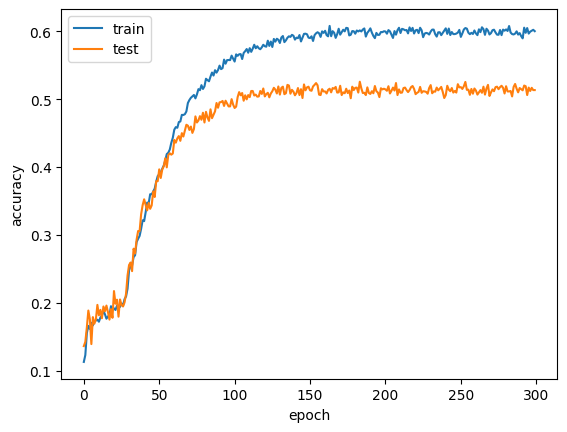

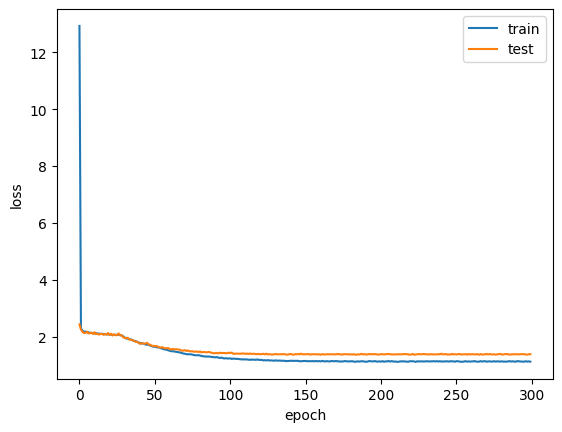

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_ReLU_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_exp.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.113429,0.136667,12.921236,2.442124
1,0.123571,0.143000,2.312923,2.262054
2,0.156000,0.164000,2.216932,2.181614
3,0.166429,0.189000,2.185550,2.140445
4,0.161857,0.176333,2.192077,2.140859


In [14]:
print(df["test_acc"].max())

0.5256666666666666


In [15]:
print(df.to_string())

     train_acc  test_acc  train_loss  test_loss
0     0.113429  0.136667   12.921236   2.442124
1     0.123571  0.143000    2.312923   2.262054
2     0.156000  0.164000    2.216932   2.181614
3     0.166429  0.189000    2.185550   2.140445
4     0.161857  0.176333    2.192077   2.140859
5     0.171000  0.139667    2.169422   2.189858
6     0.167143  0.179333    2.165221   2.126335
7     0.173143  0.169667    2.150317   2.135831
8     0.174429  0.176000    2.144677   2.152940
9     0.175571  0.197333    2.136932   2.108570
10    0.172571  0.182000    2.125250   2.170014
11    0.178857  0.190000    2.131106   2.101869
12    0.181714  0.177667    2.125112   2.115838
13    0.188571  0.195000    2.118382   2.083694
14    0.183571  0.188000    2.109292   2.111901
15    0.177000  0.196333    2.112808   2.106177
16    0.180286  0.186667    2.098805   2.079786
17    0.182286  0.175667    2.096363   2.110728
18    0.195429  0.191000    2.099069   2.085087
19    0.189857  0.178333    2.092283   2